In [1]:
import sys
sys.path.append('../')
import dmg.model2graph.model2graph as m2g
import dmg.model2graph.metafilter as mf
from networkx.algorithms.isomorphism import is_isomorphic
import dmg.graphUtils as gu
import glob
import dmg.ecore.ecorePallete as ecore
import random
random.seed(123)

# Load dataset

In [2]:
metafilter_refs = ['EClass.eSuperTypes',
                          'EClassifier.ePackage',
                           'EPackage.eClassifiers',
                           'ETypedElement.eType',
                           'EStructuralFeature.eContainingClass',
                           'EReference.eOpposite',
                           'EEnum.eLiterals',
                           'EEnumLiteral.eEnum',
                           'EClass.eStructuralFeatures']
metafilter_cla = ['EClass', 'EPackage', 'EDataType',
                         'EStructuralFeature','EEnum', 'EEnumLiteral']   
metafilter_atts = None
metafilterobj = mf.MetaFilter(references = metafilter_refs, 
                 attributes = metafilter_atts,
                 classes = metafilter_cla)       
meta_models = []

In [8]:
%cd ..
files = glob.glob("data/ecoreDataset/train/*")
graphs = []
for f in files:
    graphs.append(m2g.model2graphJava('ecore', f))
    #m2g.getGraphFromModel(f, 
                                  #meta_models, metafilterobj,
                                  #consider_atts = False)
%cd notebooks

/home/antolin/wakame/DMG-Python
/home/antolin/wakame/DMG-Python/notebooks


In [9]:
print('Number of graphs:', len(graphs))

Number of graphs: 257


In [15]:
%cd ..
files = glob.glob("data/ecoreDataset/val/*")
graphs_val = []
for f in files:
    #graphs_val.append(m2g.getGraphFromModel(f, 
    #                              meta_models, metafilterobj,
    #                              consider_atts = False))
    graphs_val.append(m2g.model2graphJava('ecore', f))
%cd notebooks

/home/antolin/wakame/DMG-Python
/home/antolin/wakame/DMG-Python/notebooks


In [16]:
print('Number of graphs:', len(graphs_val))

Number of graphs: 65


In [17]:
ecore.ecore_pallete.shuffle = False

In [18]:
from torch_geometric.data import DataLoader
from dmg.deeplearning.dataGeneration import sequence2data, data2graph
from dmg.deeplearning.dataGeneration import addInvEdges

listDatas_val = []
batch_size = 64
max_len = 2
print('Preparing seqs')
for g in graphs_val:
    sequence = ecore.ecore_pallete.graphToSequence(g)
    sequence = [(addInvEdges(s[0], ecore.ecore_pallete, ecore.ecore_separator),s[1]) for s in sequence]
    listDatas_val = listDatas_val + sequence2data(sequence, ecore.ecore_pallete, max_len)
loader_val = DataLoader(listDatas_val, batch_size=batch_size, 
                        num_workers = 0, 
                        shuffle=False)
print('Seqs finished')

Preparing seqs
Seqs finished


In [19]:
do_eval = False

if not do_eval:
    graphs = graphs + graphs_val

In [20]:
print('Number of graphs:', len(graphs))

Number of graphs: 322


# Training

In [21]:
from dmg.deeplearning.generativeModel import GenerativeModel
import torch
import torch.nn as nn
import multiprocess as mp

def f(g):
    sequence = ecore.ecore_pallete.graphToSequence(g)
    sequence = [(addInvEdges(s[0], ecore.ecore_pallete, ecore.ecore_separator),s[1]) for s in sequence]
    return sequence2data(sequence, ecore.ecore_pallete, max_len)

epochs = 200
hidden_dim = 128


criterion_node = nn.CrossEntropyLoss(reduction = 'mean',ignore_index=-1)
criterion_action = nn.CrossEntropyLoss(reduction = 'mean')
criterion_finish = nn.BCELoss(reduction = 'mean')
model = GenerativeModel(hidden_dim, ecore.dic_nodes_ecore, ecore.dic_edges_ecore, ecore.dic_operations_ecore)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
#scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.1)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    listDatas = []
    #preparing training set
    print('Preparing seqs')
    with mp.Pool(10) as pool:
        listDatas = pool.map(f, graphs)
    listDatas = [r for rr in listDatas for r in rr]
    print('Seqs finished')
    loader = DataLoader(listDatas, batch_size=batch_size, 
                            num_workers = 0, 
                            shuffle=False)
    #training
    for data in loader:
        opt.zero_grad()
        action, nodes, finish = model(data.x, data.edge_index, 
                        torch.squeeze(data.edge_attr,dim=1), 
                data.batch, data.sequence, data.nodes, data.len_seq, data.action)
        
        nodes = torch.unsqueeze(nodes, dim = 2).repeat(1,1,2)
        nodes[:,:,0] = 1 - nodes[:,:,1]
            
        L = torch.max(data.len_seq).item()
        gTruth = data.sequence_masked[:,0:L]
        loss = (criterion_node(nodes.reshape(-1,2), gTruth.flatten()) +
                    criterion_action(action, data.action) +
                    criterion_finish(finish.flatten(), data.finished.float())) / 3
        total_loss += loss.item()
        loss.backward()
        opt.step()
    #validation
    if do_eval:
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for data in loader_val:
                action, nodes, finish = model(data.x, data.edge_index, 
                            torch.squeeze(data.edge_attr,dim=1), 
                    data.batch, data.sequence, data.nodes, data.len_seq, data.action)
                nodes = torch.unsqueeze(nodes, dim = 2).repeat(1,1,2)
                nodes[:,:,0] = 1 - nodes[:,:,1]

                L = torch.max(data.len_seq).item()
                gTruth = data.sequence_masked[:,0:L]
                loss = (criterion_node(nodes.reshape(-1,2), gTruth.flatten()) +
                        criterion_action(action, data.action) +
                        criterion_finish(finish.flatten(), data.finished.float())) / 3
                val_loss+= loss.item()
        
    print('Epoch',epoch,'Loss Traning',total_loss/(len(loader)))
    #scheduler.step()
    if do_eval:
        print('Epoch',epoch,'Loss Val',val_loss/(len(loader_val)))
        

Preparing seqs
Seqs finished


/home/antolin/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 0 Loss Traning 0.4631628045868693
Preparing seqs
Seqs finished
Epoch 1 Loss Traning 0.34945211254737596
Preparing seqs
Seqs finished
Epoch 2 Loss Traning 0.3208378864960237
Preparing seqs
Seqs finished
Epoch 3 Loss Traning 0.3140031745036443
Preparing seqs
Seqs finished
Epoch 4 Loss Traning 0.30037995975351695
Preparing seqs
Seqs finished
Epoch 5 Loss Traning 0.2939612287463564
Preparing seqs
Seqs finished
Epoch 6 Loss Traning 0.2853489639519742
Preparing seqs
Seqs finished
Epoch 7 Loss Traning 0.2819291004967509
Preparing seqs
Seqs finished
Epoch 8 Loss Traning 0.27752474351136974
Preparing seqs
Seqs finished
Epoch 9 Loss Traning 0.27621414032623626
Preparing seqs
Seqs finished
Epoch 10 Loss Traning 0.2722094144220605
Preparing seqs
Seqs finished
Epoch 11 Loss Traning 0.27029626201273815
Preparing seqs
Seqs finished
Epoch 12 Loss Traning 0.2694352525991924
Preparing seqs
Seqs finished
Epoch 13 Loss Traning 0.2685938873187159
Preparing seqs
Seqs finished
Epoch 14 Loss Traning 0.2

Seqs finished
Epoch 117 Loss Traning 0.22992178549369177
Preparing seqs
Seqs finished
Epoch 118 Loss Traning 0.23229671958269496
Preparing seqs
Seqs finished
Epoch 119 Loss Traning 0.232002179787466
Preparing seqs
Seqs finished
Epoch 120 Loss Traning 0.23146909706746088
Preparing seqs
Seqs finished
Epoch 121 Loss Traning 0.22937776814355995
Preparing seqs
Seqs finished
Epoch 122 Loss Traning 0.23005094497718595
Preparing seqs
Seqs finished
Epoch 123 Loss Traning 0.23022616677211993
Preparing seqs
Seqs finished
Epoch 124 Loss Traning 0.23404722587403023
Preparing seqs
Seqs finished
Epoch 125 Loss Traning 0.23015157291383453
Preparing seqs
Seqs finished
Epoch 126 Loss Traning 0.23002262865052078
Preparing seqs
Seqs finished
Epoch 127 Loss Traning 0.229838033178539
Preparing seqs
Seqs finished
Epoch 128 Loss Traning 0.23301023019082617
Preparing seqs
Seqs finished
Epoch 129 Loss Traning 0.22936948992763506
Preparing seqs
Seqs finished
Epoch 130 Loss Traning 0.2301639337092638
Preparing se

# Loading test

In [ ]:
files = glob.glob("../data/ecoreDataset/test/*")
graphs_test = []
for f in files:
    graphs_test.append(m2g.getGraphFromModel(f, 
                                  meta_models, metafilterobj,
                                  consider_atts = False))
print('Number of graphs:', len(graphs_test))    

In [24]:
%cd ..
files = glob.glob("data/ecoreDataset/test/*")
graphs_test = []
for f in files:
    #graphs_test.append(m2g.getGraphFromModel(f, 
    #                              meta_models, metafilterobj,
    #                              consider_atts = False))
    graphs_test.append(m2g.model2graphJava('ecore', f))
%cd notebooks

/home/antolin/wakame/DMG-Python
/home/antolin/wakame/DMG-Python/notebooks


# Sample models

In [25]:
from dmg.deeplearning.generativeModel import sampleGraph
import numpy as np

model.eval()
max_size = np.max([len(g) for g in graphs])
samples = []
for i in range(max_size):
    samples.append(sampleGraph(ecore.G_initial_ecore_1, ecore.ecore_pallete, model,
                       max_size, ecore.ecore_separator, debug = False))
    print('Generated',i)

../dmg/deeplearning/generativeModel.py:133: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  m = Categorical(F.softmax(torch.squeeze(action)))
/home/antolin/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Generated 0
Generated 1
Generated 2
Generated 3
Generated 4
Generated 5
Generated 6
Generated 7
Generated 8
Generated 9
Generated 10
Generated 11
Generated 12
Generated 13
Generated 14
Generated 15
Generated 16
Generated 17
Generated 18
Generated 19
Generated 20
Generated 21
Generated 22
Generated 23
Generated 24
Generated 25
Generated 26
Generated 27
Generated 28
Generated 29
Generated 30
Generated 31
Generated 32
Generated 33
Generated 34
Generated 35
Generated 36
Generated 37
Generated 38
Generated 39
Generated 40
Generated 41
Generated 42
Generated 43
Generated 44
Generated 45
Generated 46
Generated 47
Generated 48
Generated 49
Generated 50
Generated 51
Generated 52
Generated 53
Generated 54
Generated 55
Generated 56
Generated 57
Generated 58
Generated 59
Generated 60
Generated 61
Generated 62
Generated 63
Generated 64
Generated 65
Generated 66
Generated 67
Generated 68
Generated 69
Generated 70
Generated 71
Generated 72
Generated 73
Generated 74
Generated 75
Generated 76
Generated

# Visual comparison

## Size

/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


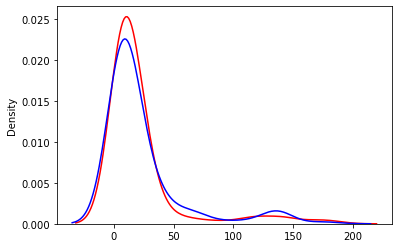

In [26]:
import seaborn as sns

sns.distplot([len(G) for G in samples], hist=False, kde=True, 
             bins=int(180/5), color = 'red', label = 'NN')
sns.distplot([len(G) for G in graphs_test], hist=False, kde=True, 
             bins=int(180/5), color = 'blue', label = 'Real')

## Degree

/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


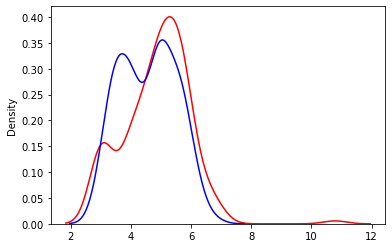

In [27]:
import numpy as np
import dmg.realism.metrics as mt
sns.distplot([np.mean(mt.getListDegree(G)) for G in samples], hist=False, kde=True, 
             bins=int(180/5), color = 'red', label = 'NN')
sns.distplot([np.mean(mt.getListDegree(G)) for G in graphs_test], hist=False, kde=True, 
             bins=int(180/5), color = 'blue', label = 'Real')

## MPC

/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


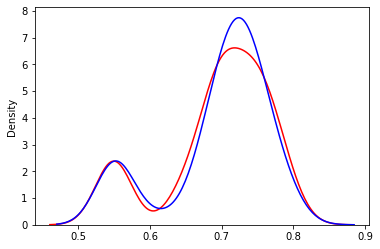

In [28]:
dims = list(ecore.dic_edges_ecore.keys())
sns.distplot([np.mean(list(mt.MPC(G,dims).values())) for G in samples], hist=False, kde=True, 
             bins=int(180/5), color = 'red', label = 'NN')
sns.distplot([np.mean(list(mt.MPC(G,dims).values())) for G in graphs_test], hist=False, kde=True, 
             bins=int(180/5), color = 'blue', label = 'Real')

In [89]:
mt.getClustList(graphs_test[0])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Check isomorf and consistency

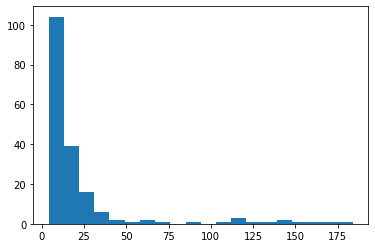

In [29]:
import matplotlib.pyplot as plt

h = plt.hist([len(G) for G in samples], bins = 20)

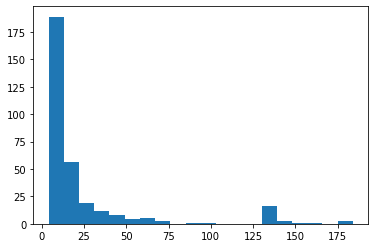

In [30]:
h = plt.hist([len(G) for G in graphs], bins = 20)

In [31]:
#check isomorf
iso = []
for s in samples:
    for g in graphs:
        if (is_isomorphic(s,g,gu.node_match_type, gu.edge_match_type)):
            iso.append(s)
            break
print(len(iso)*100/len(samples),'% iso')
not_iso = [g for g in samples if not g in iso]

22.82608695652174 % iso


Mean size: 5.238095238095238


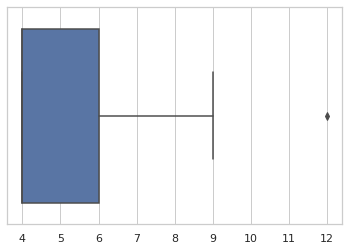

In [32]:
import numpy as np
import seaborn as sns

sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=[len(G) for G in iso])
print('Mean size:', np.mean([len(G) for G in iso]))

In [33]:
from dmg.ecore.ecoreConsistency import inconsistent
#check consistency
inconsistents = []
for s in samples:
    if inconsistent(s):
        inconsistents.append(s)
print(len(inconsistents)*100/len(samples),'% inconsistents')
not_inconsistents = [g for g in samples if not g in inconsistents]

2.1739130434782608 % inconsistents


Mean size: 106.25


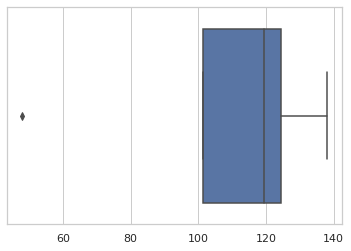

In [34]:
ax = sns.boxplot(x=[len(G) for G in inconsistents])
print('Mean size:', np.mean([len(G) for G in inconsistents]))

In [35]:
clean_new_models = [g for g in not_iso if not g in inconsistents]

Mean size: 25.08695652173913


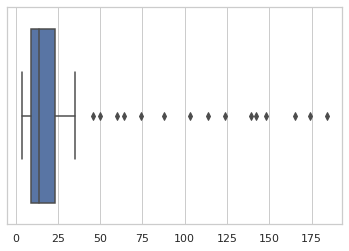

In [36]:
ax = sns.boxplot(x=[len(G) for G in clean_new_models])
print('Mean size:', np.mean([len(G) for G in clean_new_models]))

Mean size: 24.164596273291924


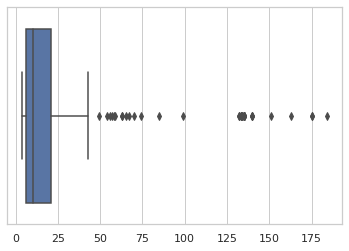

In [37]:
ax = sns.boxplot(x=[len(G) for G in graphs])
print('Mean size:', np.mean([len(G) for G in graphs]))

In [38]:
print(len(clean_new_models),'clean models')
print(len(clean_new_models)*100/len(samples),'% clean models')

138 clean models
75.0 % clean models


# Clean models

/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


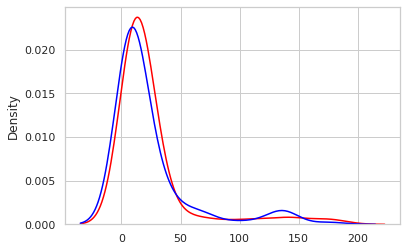

In [39]:
import seaborn as sns

sns.distplot([len(G) for G in clean_new_models], hist=False, kde=True, 
             bins=int(180/5), color = 'red', label = 'NN')
sns.distplot([len(G) for G in graphs_test], hist=False, kde=True, 
             bins=int(180/5), color = 'blue', label = 'Real')

/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


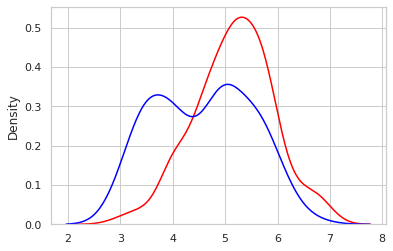

In [40]:
sns.distplot([np.mean(mt.getListDegree(G)) for G in clean_new_models], hist=False, kde=True, 
             bins=int(180/5), color = 'red', label = 'NN')
sns.distplot([np.mean(mt.getListDegree(G)) for G in graphs_test], hist=False, kde=True, 
             bins=int(180/5), color = 'blue', label = 'Real')

/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


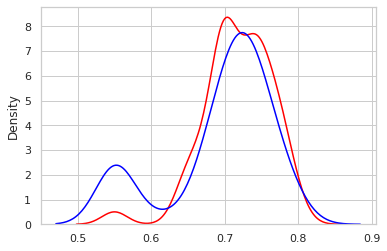

In [41]:
dims = list(ecore.dic_edges_ecore.keys())
sns.distplot([np.mean(list(mt.MPC(G,dims).values())) for G in clean_new_models], hist=False, kde=True, 
             bins=int(180/5), color = 'red', label = 'NN')
sns.distplot([np.mean(list(mt.MPC(G,dims).values())) for G in graphs_test], hist=False, kde=True, 
             bins=int(180/5), color = 'blue', label = 'Real')

# Consistent models

/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


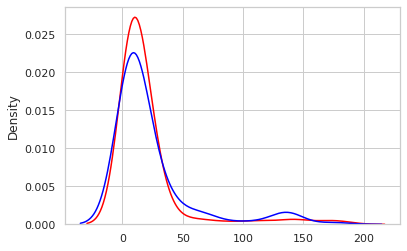

In [42]:
import seaborn as sns

sns.distplot([len(G) for G in not_inconsistents], hist=False, kde=True, 
             bins=int(180/5), color = 'red', label = 'NN')
sns.distplot([len(G) for G in graphs_test], hist=False, kde=True, 
             bins=int(180/5), color = 'blue', label = 'Real')

/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


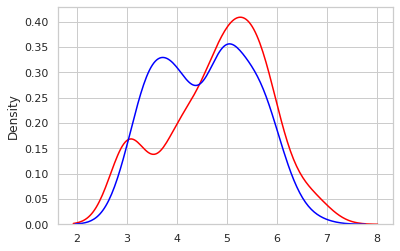

In [43]:
sns.distplot([np.mean(mt.getListDegree(G)) for G in not_inconsistents], hist=False, kde=True, 
             bins=int(180/5), color = 'red', label = 'NN')
sns.distplot([np.mean(mt.getListDegree(G)) for G in graphs_test], hist=False, kde=True, 
             bins=int(180/5), color = 'blue', label = 'Real')

/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


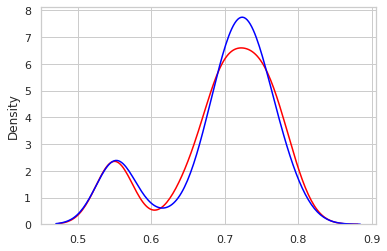

In [44]:
dims = list(ecore.dic_edges_ecore.keys())
sns.distplot([np.mean(list(mt.MPC(G,dims).values())) for G in not_inconsistents], hist=False, kde=True, 
             bins=int(180/5), color = 'red', label = 'NN')
sns.distplot([np.mean(list(mt.MPC(G,dims).values())) for G in graphs_test], hist=False, kde=True, 
             bins=int(180/5), color = 'blue', label = 'Real')

In [45]:
def uniques(Gs):
    dic = set([])
    for G1 in Gs:
        iso = False
        for G2 in dic:
            if is_isomorphic(G1, G2, gu.node_match_type, gu.edge_match_type):
                iso = True
        if not iso:
            dic.add(G1)
    return dic
len(uniques(samples))

147

In [46]:
print(len(not_inconsistents)/len(samples) * 100, '% Validity among all')
print(len(uniques(not_inconsistents))/len(not_inconsistents) * 100, '% Uniqueness among valid ones')
print(len(uniques(clean_new_models))/len(uniques(samples)) * 100, '% Novelty among unique ones')

97.82608695652173 % Validity among all
79.44444444444444 % Uniqueness among valid ones
87.75510204081633 % Novelty among unique ones


# Realism using GNN

In [71]:
from torch_geometric.data import Data
from dmg.deeplearning.dataGeneration import generateTensorsFromGraph
syns = []
sett = not_inconsistents#samples#clean_new_models#samples
for G in random.sample(sett,min(len(sett),len(graphs_test))):
    G_inv = addInvEdges(G, ecore.ecore_pallete, ecore.ecore_separator)
    tensors = generateTensorsFromGraph(G_inv, ecore.ecore_pallete, 2, 2)
    data =  Data(x = tensors[0],
                edge_index = tensors[-2], 
                edge_attr = tensors[-1],
                y = torch.tensor(0))
    syns.append(data)

In [72]:
reals = []
#graphs_test = [g for g in graphs_test if len(g.edges) >= 1]
for G in random.sample(graphs_test,min(len(sett),len(graphs_test))):
    G_inv = addInvEdges(G, ecore.ecore_pallete, ecore.ecore_separator)
    tensors = generateTensorsFromGraph(G_inv, ecore.ecore_pallete, 2, 2)
    data =  Data(x = tensors[0],
                edge_index = tensors[-2], 
                edge_attr = tensors[-1],
                y = torch.tensor(1))
    reals.append(data)

In [73]:
dataset = syns + reals
random.shuffle(dataset)
print('Len train:', len(dataset))

Len train: 276


In [74]:
from torch.utils.data import random_split
import torch
train_len = int(0.8*len(dataset))
test_len = len(dataset) - int(0.8*len(dataset))
train, test = random_split(dataset, [train_len, test_len], 
                                generator=torch.Generator().manual_seed(42))

In [75]:
train_loader = DataLoader(train, batch_size=32, num_workers = 5, shuffle=True)
test_loader = DataLoader(test, batch_size=1, num_workers = 5, shuffle=True)

In [76]:
import torch.nn as nn
from dmg.realism.discriminativeModel import DiscriminativeModel

model = DiscriminativeModel(64,64,0.0,ecore.dic_nodes_ecore,ecore.dic_edges_ecore).cpu()

epochs = 40
criterion = nn.BCELoss()

opt = torch.optim.Adam(model.parameters(), lr=0.001)


for e in range(epochs):
    total_loss = 0.0
    b = 1
    model.train()
    for data in train_loader:
        
        opt.zero_grad()
        
        pred = model(data.x.cpu(), data.edge_index.cpu(),
          torch.squeeze(data.edge_attr.cpu(),dim=1),data.batch.cpu())
        
        loss = criterion(torch.squeeze(pred, dim = 1), data.y.float().cpu())
        total_loss += loss.item()
        
        loss.backward()
        opt.step()
        b = b + 1
        
    print('Epoch',e,'Loss',total_loss/b)


Epoch 0 Loss 0.5925427302718163


/home/antolin/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 1 Loss 0.5612660273909569
Epoch 2 Loss 0.5306978672742844
Epoch 3 Loss 0.517370842397213
Epoch 4 Loss 0.5057508498430252
Epoch 5 Loss 0.4989812858402729
Epoch 6 Loss 0.5016606524586678
Epoch 7 Loss 0.47887153923511505
Epoch 8 Loss 0.5077777951955795
Epoch 9 Loss 0.4643038362264633
Epoch 10 Loss 0.4454215541481972
Epoch 11 Loss 0.44725289195775986
Epoch 12 Loss 0.42965133860707283
Epoch 13 Loss 0.4320457875728607
Epoch 14 Loss 0.4150043986737728
Epoch 15 Loss 0.4014209471642971
Epoch 16 Loss 0.4040917791426182
Epoch 17 Loss 0.38347844406962395
Epoch 18 Loss 0.3807491958141327
Epoch 19 Loss 0.38019560649991035
Epoch 20 Loss 0.38548872247338295
Epoch 21 Loss 0.36960672959685326
Epoch 22 Loss 0.3563331551849842
Epoch 23 Loss 0.36511608585715294
Epoch 24 Loss 0.36730241402983665
Epoch 25 Loss 0.4076543599367142
Epoch 26 Loss 0.3885907530784607
Epoch 27 Loss 0.3514903001487255
Epoch 28 Loss 0.34683289378881454
Epoch 29 Loss 0.3303845003247261
Epoch 30 Loss 0.37815211340785027
Epoch 31 

In [77]:
model.eval()
count = 0
i0 = 0
i1 = 0
for data in test_loader:
    pred = model(data.x.cpu(), data.edge_index.cpu(),
          torch.squeeze(data.edge_attr,dim=1).cpu(),data.batch.cpu())
    if pred[0].item() > 0.5:
        pred = 1
    else:
        pred = 0
    if pred == data.y.long().item():
        count = count + 1
    
print('Acc', count/len(test_loader))

Acc 0.6964285714285714


In [78]:
import scipy.stats as st
import math

def C2ST_pvalue(acc,n_test):
    return st.norm.cdf(-(acc-0.5)/(math.sqrt(1/(4*n_test))))

print('p-value', C2ST_pvalue(count/len(test_loader),len(test_loader)))

p-value 0.0016417304930345215


# Plot a sample of clean models

In [85]:
dot = gu.plotGraphViz(random.sample(clean_new_models,1)[0])
dot.format = 'pdf'
dot.view(filename='example', directory='./')

'./example.pdf'

In [ ]:
#m2g.getModelFromGraph(['../data/metamodels/yakinduSimplified.ecore'], clean_new_models[0])

In [ ]:
m2g.serializeGraphModel('example.xmi',['../data/metamodels/yakinduSimplified.ecore'], 'Statechart', clean_new_models[0])